**This code example works with raw MS Data downloaded from the MetaboLights repository (~ 1 GiB). The running time for the code in this notebook is approximately 30 s (excluding the time required to download the data), using a personal computer with an 8th generation Intel i5 processor and 8 GiB memory.**

# Application 1: System suitability check, and signal drift evaluation

This notebook introduces the analysis of the application #1 published in [Metabolites](https://doi.org/10.3390/metabo10100416). It shows how to work with raw data using as an example a System Suitability Check conducted in a metabolomics experiment: System Suitability Samples (SSS) were prepared using five known chemical standards:

* Alogliptin
* Phe-Phe
* Tryptophan
* LPC 18:0
* Leu-Enk

Ten SSS samples (addressed as SSS1) were consecutively run and used to build an acceptance criteria, and then compared against values obtained from the analysis of SSS samples that were analyzed before (SSS2) and after (SSS3) the study samples. This analysis is displayed in Figure 3.

A similar analysis was conducted using QC samples that were spiked with the same compounds and with Leu-13C used as internal standard, but in this case, no acceptance criteria was defined. These results are displayed in Figure S1.


<img src="fig/sample-list.png" width=700>
Sample list used in the experiment. The first SSS sample is the SSS2 and the second SSS sample is SSS3. SSS1 is not shown in this figure.

**UPDATE 2022-06**: The code has been modified to work with the Assay object. See [this link](agregar) for a description on how to work with Assay objects.

In [3]:
import tidyms as ms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from download_from_metabolights import get_application1_data
pd.set_option("display.precision", 4)
sns.set_context("paper", font_scale=1.5)
import bokeh.plotting

## Loading data from Metabolights

In [7]:
# Setting the raw data path and a DataFrame with sample metadata
data_path = "data"
get_application1_data(data_path)  # download data from metabolights
sample_list_path = os.path.join(data_path, "sample_list.csv")
centroid_data_path = os.path.join(data_path, "cent")
sample_list = pd.read_csv(sample_list_path)
# sample_list = sample_list[~(sample_list["class"] == "SCQC")]

data directory found. Checking files...
sample_list.csv found
Centroid data found.


In [8]:
# compounds used for SSS check, with their m/z and expected retention times
d = {
    "Compound": ["Leu-13C", "Trp", "Phe-Phe", "Alogliptin", "LPC 18:0", "Leu-Enk"],
     "rt": np.array([75, 129, 320, 291, 775, 372]),
     "mz": np.array([133.1056, 205.0977,313.1552, 340.1773, 524.3716, 556.2771])
}
df = pd.DataFrame(data=d)

## Feature Detection

In [9]:
# create assay
assay = ms.Assay(assay_path="sss", data_path="data/cent", sample_metadata=sample_list)

In [10]:
# ROI creation
mz = np.array([133.1056, 205.0977,313.1552, 340.1773, 524.3716, 556.2771])
roi_params = {"targeted_mz": d["mz"], "min_intensity": 500}
assay.detect_features(n_jobs=-1, **roi_params)

Creating ROI in 31 samples


  0%|          | 0/31 [00:00<?, ?it/s]

## Feature extraction

In [13]:
# peak detection
assay.extract_features(n_jobs=-1, store_smoothed=True)

All samples are processed already.


In [14]:
# peak descriptors
assay.describe_features(n_jobs=-1)

All samples are processed already.


## Feature correspondence

In [15]:
# build feature table
assay.build_feature_table()

In [16]:
assay.feature_table

,height,area,rt,width,snr,mz,mz_std,roi_index,ft_index,sample_,class_
0,5100.2873,29687.2587,126.4572,13.034,58.5547,205.0956,0.0021,0,0,NZ_20200226_005,SSS1
1,8687.0065,45385.6398,322.6155,13.377,151.2077,313.1536,0.0027,1,0,NZ_20200226_005,SSS1
2,45765.0120,227196.9253,294.3848,14.063,979.9375,340.1767,0.0019,2,0,NZ_20200226_005,SSS1
3,762.2988,3510.5526,382.3073,8.231,10.8818,313.1543,0.0022,3,0,NZ_20200226_005,SSS1
4,37620.4533,172109.2124,370.1068,12.348,831.9544,556.2758,0.0033,4,0,NZ_20200226_005,SSS1
...,...,...,...,...,...,...,...,...,...,...,...
264,8265.8058,42791.2937,319.2983,11.318,185.8400,313.1546,0.0020,2,0,NZ_20200227_097,SSS3
265,452.9191,1925.0448,379.6876,8.231,31.3322,313.1540,0.0021,3,0,NZ_20200227_097,SSS3
266,19552.4259,93398.0168,367.2253,14.406,517.1730,556.2775,0.0045,4,0,NZ_20200227_097,SSS3
267,800.4986,2236.6328,614.4362,5.145,63.5210,556.2799,0.0053,5,0,NZ_20200227_097,SSS3


In [17]:
# feature correspondence
assay.match_features(include_classes=["QC"], verbose=True)

  0%|          | 0/10 [00:00<?, ?it/s]

## Data matrix creation

In [18]:
data = assay.make_data_matrix()

In [19]:
data.data_matrix

feature,FT-01,FT-02,FT-03,FT-04,FT-05,FT-06,FT-07,FT-08,FT-09,FT-10
sample,,,,,,,,,,
NZ_20200226_005,29687.2587,45385.6398,227196.9253,3510.5526,172109.2124,10700.2131,1.1248e+05,0.0000,0.0000,0.0000
NZ_20200226_007,23303.3767,36845.0146,197653.9777,2389.9621,147394.5805,8043.9721,9.7550e+04,0.0000,0.0000,0.0000
NZ_20200226_009,21696.3856,32698.4720,178590.4239,2439.4173,127465.0215,7896.6520,8.3843e+04,0.0000,0.0000,0.0000
NZ_20200226_011,21699.8050,32254.1191,175006.9869,2012.0643,123648.7696,6635.8827,7.9256e+04,0.0000,0.0000,0.0000
NZ_20200226_013,20557.6590,31185.2033,162144.5227,2174.9385,120143.2677,7444.5323,7.8299e+04,0.0000,0.0000,0.0000
NZ_20200226_015,22441.9440,30730.3082,160406.7497,1843.1274,121449.4319,6475.1786,7.5200e+04,0.0000,0.0000,0.0000
NZ_20200226_017,23300.7397,34499.3080,166838.1433,2125.1056,120773.9473,7466.6962,7.5494e+04,0.0000,0.0000,0.0000
NZ_20200226_019,24819.7283,35188.8150,180755.6583,2540.8586,120004.8839,7418.4143,8.2374e+04,0.0000,0.0000,0.0000
NZ_20200226_021,26282.8932,35312.2013,184494.4814,2162.6134,129627.4287,7273.0578,8.1387e+04,0.0000,0.0000,0.0000


In [33]:
data.feature_metadata

,mz,mz max,mz min,mz std,rt,rt max,rt min,rt std
feature,,,,,,,,
FT-01,205.0967,205.0999,205.0946,0.0010,126.2393,126.8737,125.7227,0.2236
FT-02,313.1541,313.1576,313.1516,0.0012,320.4888,322.6155,319.2983,0.9521
FT-03,340.1762,340.1802,340.1739,0.0016,292.0319,294.3848,290.4892,1.2491
FT-04,313.1537,313.1573,313.1505,0.0016,380.8146,382.3073,379.4224,0.8351
FT-05,556.2759,556.2796,556.2702,0.0021,368.2295,370.1068,367.1828,0.9002
FT-06,524.3708,524.3749,524.3657,0.0022,757.1460,757.4407,756.5396,0.2328
FT-07,524.3710,524.3791,524.3669,0.0027,776.1277,776.5611,775.4882,0.2187
FT-08,133.1059,133.1077,133.1045,0.0008,73.8190,74.1445,73.1463,0.2598
FT-09,313.1590,313.1616,313.1560,0.0016,775.6581,776.2188,775.3269,0.2566


## Remove unwanted features using the Retention times from the standards

In [20]:
# find the compounds used in the SSS using the expected rt 
ft_to_compound = dict()
for index in df.index:
    mz = df.loc[index, "mz"]
    rt = df.loc[index, "rt"]
    compound = df.loc[index, "Compound"]
    ft = data.select_features(mz, rt)
    ftid = int(ft[0].split("-")[-1]) - 1
    ft_to_compound[ftid] = compound

## Figure 3: m/z, Rt and area dispersion for SSS samples

In [21]:
feature_table = assay.feature_table.copy()
feature_table["Compound"] = feature_table["cluster_"].map(ft_to_compound)

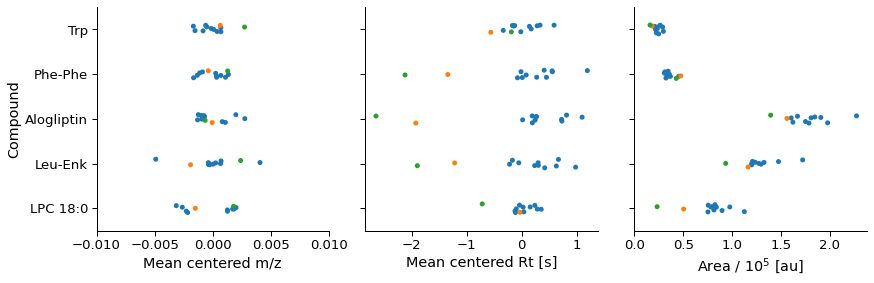

In [22]:
# FIGURE 3: 

sss_mask = feature_table["class_"].isin(["SSS1", "SSS2", "SSS3"])
sss_data = feature_table[sss_mask].copy()
# sss_data = sss_data[sss_data["Compound"] != 'LPC 18:0']

# compute mean centered m/z and rt
mean_mz = sss_data["mz"].groupby(sss_data["Compound"]).mean()
mean_rt = sss_data["rt"].groupby(sss_data["Compound"]).mean()
sss_data["mean mz"] = \
    (sss_data["mz"].groupby(sss_data["Compound"])
     .apply(lambda x: x - mean_mz[x.name]))

sss_data["mean rt"] = \
    (sss_data["rt"].groupby(sss_data["Compound"])
     .apply(lambda x: x - mean_rt[x.name]))

xvars = ["mean mz", "mean rt", "area"]
g = sns.PairGrid(data=sss_data,
                 y_vars=["Compound"],
                 x_vars=xvars,
                 hue="class_",
                 hue_kws={"marker": [".", "X", "D"], "size": [8, 8, 8]},
                 height=4)
g.map(sns.stripplot)

# setting plot properties
g.axes[0, 0].set_xlim(-0.01, 0.01)
g.axes[0, 2].set_xticks(np.linspace(0, 2e5, 5))
t = g.axes[0, 2].get_xticks()
t = [str(x / 100000) for x in t ]
g.axes[0, 2].set_xticklabels(t);
g.axes[0, 0].set_xlabel("Mean centered m/z")
g.axes[0, 1].set_xlabel("Mean centered Rt [s]")
g.axes[0, 2].set_xlabel("Area / $10^{5}$ [au]");
# g.savefig("metabolomics-2020-sss.png", dpi=300)

 ## Figure S2: m/z, Rt and area dispersion for QC samples

Text(0.5, 8.916666666666659, 'Area / $10^{5}$ [au]')

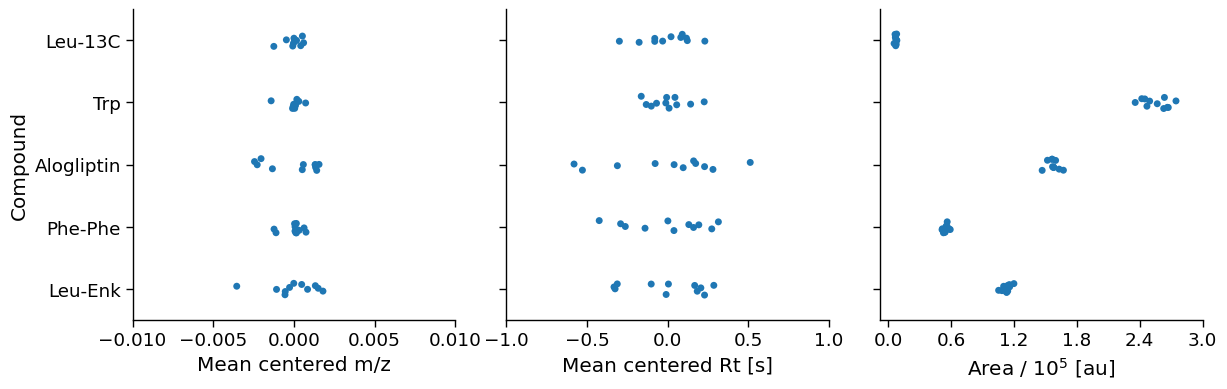

In [23]:
# FIGURE S1: 

# also remove LPC 18:0 because the area has much higher values
qc_mask = feature_table["class_"].isin(["QC"]) & (feature_table["Compound"] != "LPC 18:0")
qc_data = feature_table[qc_mask].copy()

# compute mean centered m/z and rt
mean_mz = qc_data["mz"].groupby(qc_data["cluster_"]).mean()
mean_rt = qc_data["rt"].groupby(qc_data["cluster_"]).mean()
qc_data["mean_mz"] = \
    (qc_data["mz"].groupby(qc_data["cluster_"])
     .apply(lambda x: x - mean_mz[x.name]))

qc_data["mean_rt"] = \
    (qc_data["rt"].groupby(qc_data["cluster_"])
     .apply(lambda x: x - mean_rt[x.name]))
# sss_data = sss_data.rename(columns={"area": "Area / 10e5 [au]"})

xvars = ["mean_mz", "mean_rt", "area"]
g = sns.PairGrid(data=qc_data,
                 y_vars=["Compound"],
                 x_vars=xvars,
                 hue="class_",
                 height=4)
g.map(sns.stripplot)
g.axes[0, 0].set_xlim(-0.01, 0.01)
g.axes[0, 1].set_xlim(-1, 1)
g.axes[0, 2].set_xticks(np.linspace(0, 3e5, 6))

# ticks for lpc
# g.axes[0, 2].set_xticks(np.linspace(2e6, 7e6, 6))
t = g.axes[0, 2].get_xticks()
# t = [str(x / 100000) + "e05" if x != 0 else "0" for x in t ]
t = [str(x / 100000) for x in t ]
g.axes[0, 2].set_xticklabels(t);g.axes[0, 0].set_xlabel("Mean centered m/z")
g.axes[0, 1].set_xlabel("Mean centered Rt [s]")
g.axes[0, 2].set_xlabel("Area / $10^{5}$ [au]")
# g.savefig("rt_mz_area_qc_lpc.png", dpi=300)